In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM,Dense
from keras.metrics import MeanSquaredError,MeanAbsoluteError

In [2]:
df=pd.read_csv('multidata.csv')
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df

,Date,Close,Revenue,GDP
Date,,,,
2017-04-03,2017-04-03,65.550003,22.1,19201.33734
2017-04-04,2017-04-04,65.730003,22.1,19201.33734
2017-04-05,2017-04-05,65.559998,22.1,19201.33734
2017-04-06,2017-04-06,65.730003,22.1,19201.33734
2017-04-07,2017-04-07,65.680000,22.1,19201.33734
...,...,...,...,...
2021-04-26,2021-04-26,261.549988,41.7,22606.30254
2021-04-27,2021-04-27,261.970001,41.7,22606.30254
2021-04-28,2021-04-28,254.559998,41.7,22606.30254


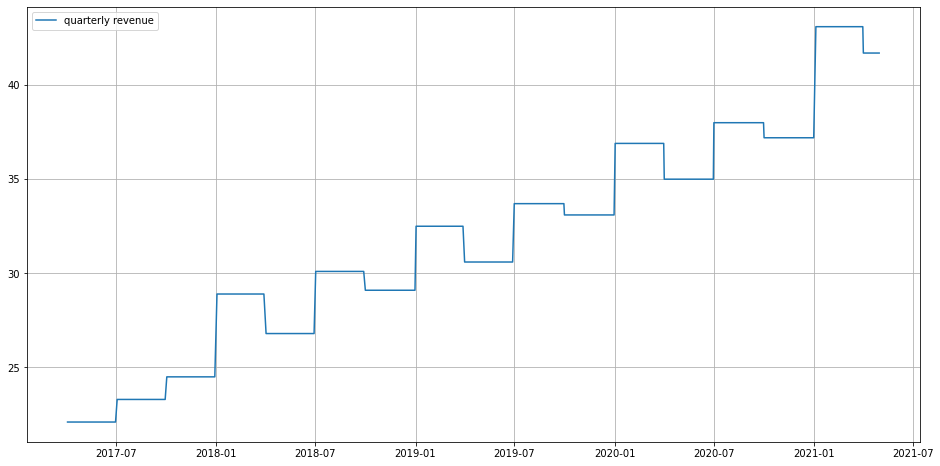

In [4]:
revenue=df['Revenue']
plt.figure(figsize=(16,8))
plt.plot(revenue, label='quarterly revenue')
plt.legend()
plt.grid()

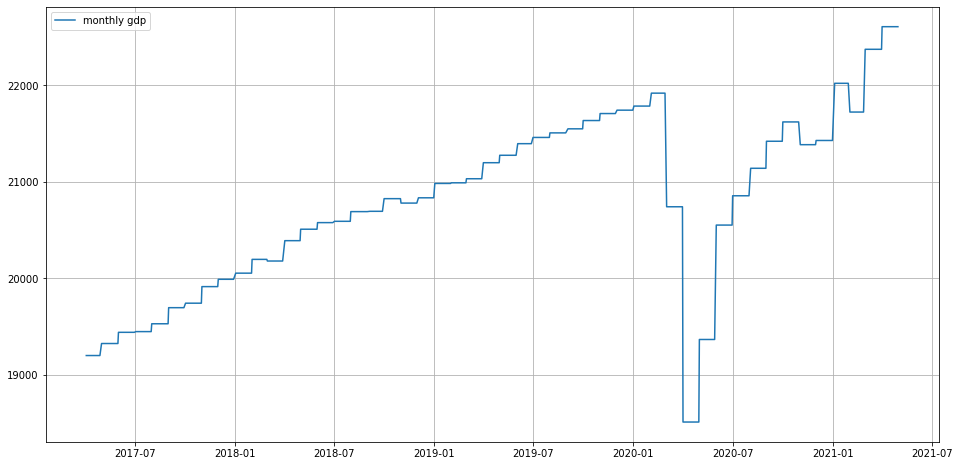

In [4]:
gdp=df['GDP']
plt.figure(figsize=(16,8))
plt.plot(gdp, label='monthly gdp')
plt.legend()
plt.grid()

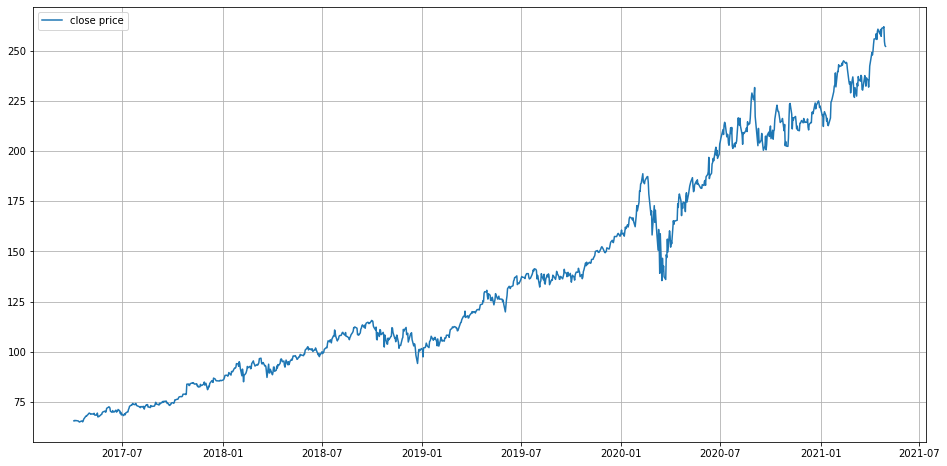

In [5]:
price=df['Close']
plt.figure(figsize=(16,8))
plt.plot(price, label='close price')
plt.legend()
plt.grid()

In [6]:
#price normalization
price=price.values.reshape(price.shape[0],1)
sca_p=MinMaxScaler()
price=sca_p.fit_transform(price)

In [8]:
price[0,0]

0.0030454064958805316

In [9]:
#gdp normalization
gdp=gdp.values.reshape(gdp.shape[0],1)
sca_g=MinMaxScaler()
gdp=sca_g.fit_transform(gdp)

In [10]:
#revenue normalization
revenue=revenue.values.reshape(revenue.shape[0],1)
sca_r=MinMaxScaler()
revenue=sca_r.fit_transform(revenue)

In [11]:
data=np.hstack((price,revenue,gdp))
data

array([[0.00304541, 0.        , 0.16821226],
       [0.00395902, 0.        , 0.16821226],
       [0.00309614, 0.        , 0.16821226],
       ...,
       [0.96238959, 0.93333333, 1.        ],
       [0.95198454, 0.93333333, 1.        ],
       [0.95030957, 0.93333333, 1.        ]])

In [13]:
data[:,0]

array([0.00304541, 0.00395902, 0.00309614, ..., 0.96238959, 0.95198454,
       0.95030957])

In [10]:
#split x and y
x=[]
y=[]
for i in range(30,len(data)):
    x.append(data[i-30:i])
    y.append(price[i,0])
x=np.array(x)
y=np.array(y)

In [11]:
#split train and test
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=3)

In [12]:
#build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(30,3)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [17]:
#train
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/5
747/747 - 10s - loss: 4.8366e-04 - 10s/epoch - 14ms/step
Epoch 2/5
747/747 - 7s - loss: 5.2908e-04 - 7s/epoch - 10ms/step
Epoch 3/5
747/747 - 8s - loss: 4.6182e-04 - 8s/epoch - 10ms/step
Epoch 4/5
747/747 - 8s - loss: 3.7397e-04 - 8s/epoch - 10ms/step
Epoch 5/5
747/747 - 8s - loss: 4.0261e-04 - 8s/epoch - 10ms/step


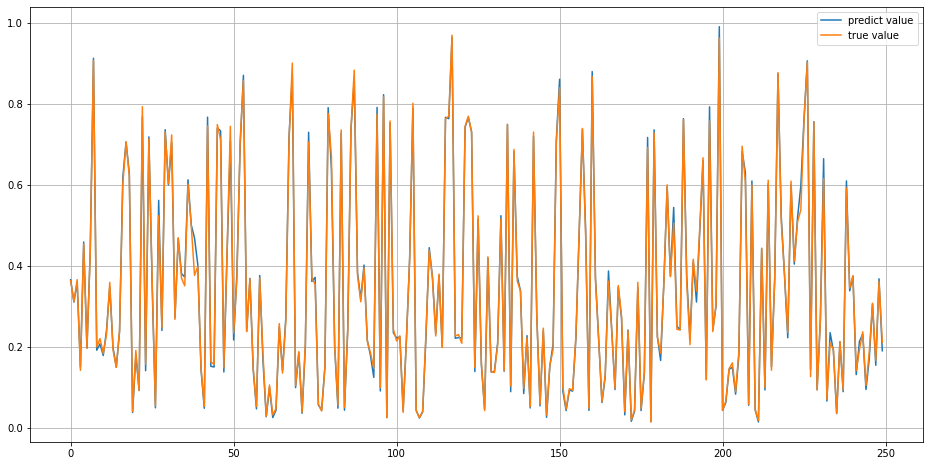

In [18]:
#test
y_predict=model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(y_predict,label='predict value')
plt.plot(y_test,label='true value')

plt.legend()
plt.grid()

In [12]:
model=load_model('model2_new.h5')
y_predict=model.predict(x_test)

In [26]:
m = MeanSquaredError()
m.update_state(y_predict,y_test)
m.result().numpy()

0.0001732461

In [21]:
print(m.result().numpy())

28.106976


In [27]:
a=MeanAbsoluteError()
a.update_state(y_predict,y_test)
a.result().numpy()

0.0086082965

In [28]:
r=r2_score(y_predict,y_test)
r

0.9973891096162949

In [29]:
residual=np.ravel(y_predict)-y_test
print(np.mean(residual))
print(np.median(residual))
print(skew(residual))

0.00034383009385864004
-0.001617877402129736
2.0614344247902814


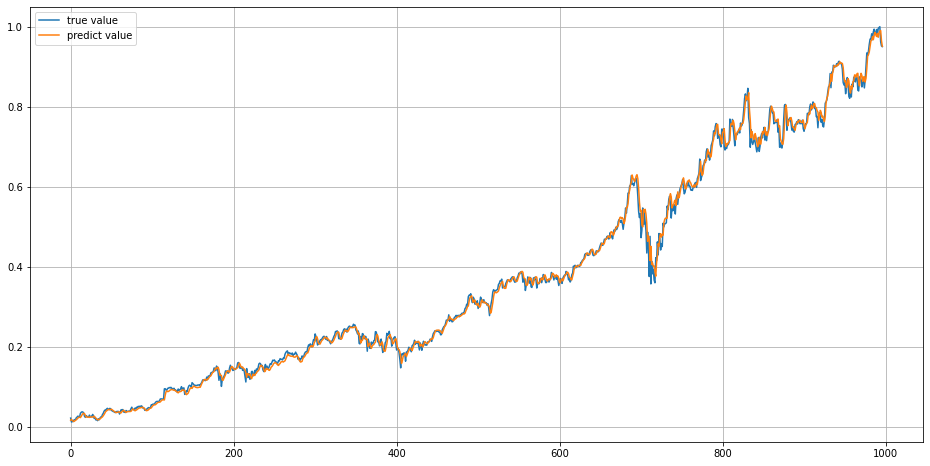

In [23]:
#predict all data
predict_all=model.predict(x)

plt.figure(figsize=(16,8))
plt.plot(y,label='true value')
plt.plot(predict_all,label='predict value')
plt.legend()
plt.grid()

In [13]:
#read May true values
May=pd.read_csv('MSFT_21May.csv')
y_May=May['Close'].values.reshape(May.shape[0],1)

In [14]:
#predict May
predict_May=[]
ans=x[-1:]
cur=y[-1]
for _ in range(len(y_May)):
    ans[0]=np.vstack((ans[0][1:],np.array([cur,1,1])))
    cur=model.predict(ans)[0][0]
    predict_May.append(cur)
predict_May=np.array(predict_May) 

In [15]:
#transform
a=predict_May.reshape(predict_May.shape[0],1)
predict_May=sca_p.inverse_transform(a)

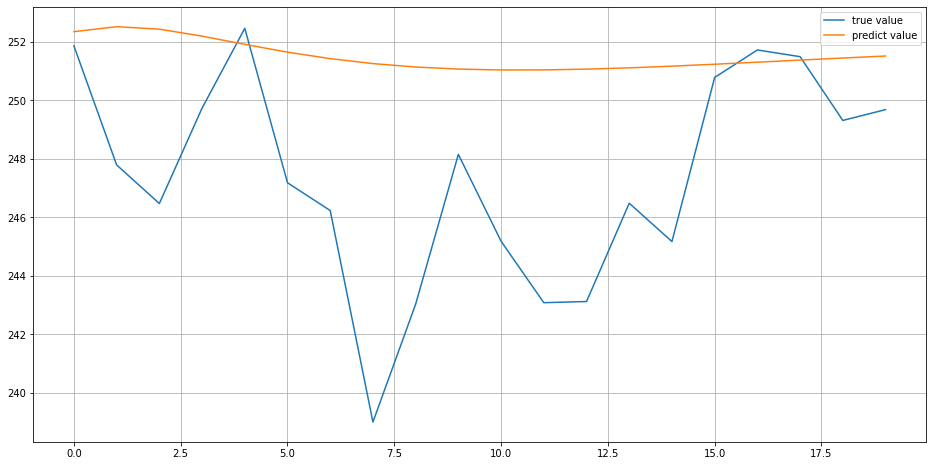

In [16]:
plt.figure(figsize=(16,8))
plt.plot(y_May,label='true value')
plt.plot(predict_May,label='predict value')
plt.legend()
plt.grid()

In [19]:
a=MeanAbsoluteError()
a.update_state(predict_May,y_May)
a.result().numpy()

4.2226653

In [18]:
m = MeanSquaredError()
m.update_state(predict_May,y_May)
m.result().numpy()

28.106976